## import

In [2]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from utils import *
import cv2

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# Pretrained Model
import segmentation_models_pytorch as smp

# torchvision Models
import torchvision
from torchvision import models
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

plt.rcParams['axes.grid'] = False

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))

print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장
%matplotlib inline

pytorch version: 1.5.0+cu101
GPU 사용 가능 여부: True
Tesla V100-PCIE-32GB
1


## 하이퍼파라미터 세팅 및 seed 고정

In [3]:
batch_size = 10   # Mini-batch size
num_epochs = 20
learning_rate = 1e-4

In [4]:
# seed 고정
random_seed = 42
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
# torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

## 학습 데이터 EDA

In [5]:
dataset_path = '../input/data'
anns_file_path = dataset_path + '/' + 'train.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 11
Number of categories: 11
Number of annotations: 21116
Number of images: 2617


In [6]:
# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']] += 1

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

## 데이터 전처리 함수 정의 (Dataset)

In [7]:
# category labeling 
sorted_temp_df = df.sort_index()

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)

category_names = list(sorted_df.Categories)

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        #images /= 255.0
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id + 1" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # Unknown = 1, General trash = 2, ... , Cigarette = 11
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks = np.maximum(self.coco.annToMask(anns[i])*pixel_value, masks)
            masks = masks.astype(np.float32)

            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            
            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            
            return images, image_infos
    
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())

## Dataset 정의 및 DataLoader 할당

In [8]:
# train.json / validation.json / test.json 디렉토리 설정
train_path = dataset_path + '/train.json'
val_path = dataset_path + '/val.json'
test_path = dataset_path + '/test.json'

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

train_transform = A.Compose([
                            A.OneOf([
                                #A.ElasticTransform(border_mode=1,p=0.4),
                                A.GridDistortion(border_mode=1,p=0.5),
                            ],p=1),
                            A.OneOf([
                                A.Rotate(border_mode=1,p=0.6),
                                A.ShiftScaleRotate(border_mode=1,p=0.6),
                            ],p=1),
                            A.Flip(p=0.5),
                            A.Blur(p=0.4),
                            A.RandomBrightnessContrast(p=0.4),
                            A.Normalize(
                                mean=(0.485, 0.456, 0.406),
                                std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0
                            ),
                            ToTensorV2(transpose_mask=True),
                            ])

val_transform = A.Compose([
                            A.Normalize(
                                mean=(0.485, 0.456, 0.406),
                                std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0
                            ),
                            ToTensorV2(transpose_mask=True),
                        ])

test_transform = A.Compose([
                            A.Normalize(
                                mean=(0.485, 0.456, 0.406),
                                std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0
                            ),
                            ToTensorV2(transpose_mask=True),
                           ])

# create own Dataset 1 (skip)
# validation set을 직접 나누고 싶은 경우
# random_split 사용하여 data set을 8:2 로 분할
# train_size = int(0.8*len(dataset))
# val_size = int(len(dataset)-train_size)
# dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=transform)
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# create own Dataset 2
# train dataset
train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=train_transform)

# validation dataset
val_dataset = CustomDataLoader(data_dir=val_path, mode='val', transform=val_transform)

# test dataset
test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=test_transform)


# DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=0,
                                           collate_fn=collate_fn)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=0,
                                         collate_fn=collate_fn)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          num_workers=1,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=4.39s)
creating index...
index created!
loading annotations into memory...
Done (t=0.89s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


### Train Augmentation 확인 (Show example image and mask)

In [9]:
'''
# train_loader의 output 결과(image 및 mask) 확인
for imgs, masks, image_infos in train_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = masks
    
    break

for idx in range(batch_size):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))
    print('image shape:', list(temp_images[idx].shape))
    print('mask shape: ', list(temp_masks[idx].shape))
    print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[idx]))])

    ax1.imshow(temp_images[idx].permute([1,2,0]))
    ax1.grid(False)
    ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

    ax2.imshow(temp_masks[idx])
    ax2.grid(False)
    ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

    plt.show()
'''

'\n# train_loader의 output 결과(image 및 mask) 확인\nfor imgs, masks, image_infos in train_loader:\n    image_infos = image_infos[0]\n    temp_images = imgs\n    temp_masks = masks\n    \n    break\n\nfor idx in range(batch_size):\n    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))\n    print(\'image shape:\', list(temp_images[idx].shape))\n    print(\'mask shape: \', list(temp_masks[idx].shape))\n    print(\'Unique values, category of transformed mask : \n\', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[idx]))])\n\n    ax1.imshow(temp_images[idx].permute([1,2,0]))\n    ax1.grid(False)\n    ax1.set_title("input image : {}".format(image_infos[\'file_name\']), fontsize = 15)\n\n    ax2.imshow(temp_masks[idx])\n    ax2.grid(False)\n    ax2.set_title("masks : {}".format(image_infos[\'file_name\']), fontsize = 15)\n\n    plt.show()\n'

## baseline model

### DeepLabV3+ (ResNext101)

In [10]:
model = smp.DeepLabV3Plus('se_resnext101_32x4d', encoder_weights="imagenet", classes=12)

In [11]:
def freeze(Model,idx):
    for m in list(Model.children()):
        for param in m.parameters():
            param.requires_grad=True

    for m in list(Model.children())[:idx]:
        for param in m.parameters():
            param.requires_grad=False

def Unfreeze(Model):
    for m in list(Model.children()):
        for param in m.parameters():
            param.requires_grad=True

## Dice Loss

In [12]:
def diceCoeffv2(pred, gt, eps=1e-5, activation='softmax2d'):
    """ computational formula：
        dice = (2 * tp) / (2 * tp + fp + fn)
    """
 
    if activation is None or activation == "none":
        activation_fn = lambda x: x
    elif activation == "sigmoid":
        activation_fn = nn.Sigmoid()
    elif activation == "softmax2d":
        activation_fn = nn.Softmax2d()
    else:
        raise NotImplementedError("Activation implemented for sigmoid and softmax2d activation function operation")
 
    pred = activation_fn(pred)
    # gt -> one-hot encoding
    gt = F.one_hot(gt, num_classes = 12).permute(0,3,1,2).contiguous()
    N = gt.size(0)
    pred_flat = pred.view(N, -1)
    gt_flat = gt.view(N, -1)
 
    tp = torch.sum(gt_flat * pred_flat, dim=1)
    fp = torch.sum(pred_flat, dim=1) - tp
    fn = torch.sum(gt_flat, dim=1) - tp
    loss = (2 * tp + eps) / (2 * tp + fp + fn + eps)
    return loss.sum() / N

class DiceScore(nn.Module):
    __name__ = 'dice_score'
    def __init__(self, activation='softmax2d'):
        super(DiceScore, self).__init__()
        self.activation = activation
 
    def forward(self, y_pr, y_gt):
        return diceCoeffv2(y_pr, y_gt, activation=self.activation)

## Custom Loss

In [13]:
class DiceCELoss(nn.Module):
    def __init__(self):
        super(DiceCELoss, self).__init__()
        self.DiceScore=DiceScore()
        self.CELoss=nn.CrossEntropyLoss()
    
    def forward(self,y_pr,y_gt):
        return self.CELoss(y_pr,y_gt)-torch.log(self.DiceScore(y_pr,y_gt))

In [14]:
def class_score(avrg_class_IoU):
    # Class Score
    class_name=['BG','UNK','General Trash','Paper','Paper pack','Metal','Glass','Plastic','Styrofoam','Plastic Bag','Battery','Clothing']
    print('-'*20)
    print('Validation Class Pred mIoU Score')
    for idx, class_score in enumerate(avrg_class_IoU):
        print('[{}] mIoU : [{:.4f}]'.format(class_name[idx],class_score))
    print('-'*20) 

## train, validation, test 함수 정의

In [15]:
def train(num_epochs, model, data_loader, val_loader, criterion, optimizer, scheduler, saved_dir, device):
    model.to(device)
    print('Start training..')
    best_loss = 9999999
    best_IoU = 0
    freeze(model,-2)
    for epoch in range(num_epochs):
        train_loss=[]
        model.train()
        if epoch==3: Unfreeze(model)
        for step, (images, masks, _) in enumerate(tqdm(data_loader)):
            images = torch.stack(images)       # (batch, channel, height, width)
            masks = torch.stack(masks).long()  # (batch, channel, height, width)
            
            # gpu 연산을 위해 device 할당
            images, masks = images.to(device), masks.to(device)
            
            # inference
            outputs = model(images)

            # loss 계산 (cross entropy loss)
            loss = criterion(outputs, masks)
            train_loss.append(loss.item())
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            #Cosine Annealing Scheduler
            scheduler.step(epoch + step / len(data_loader))
        
        #scheduler.step(avrg_loss)
        # validation 주기에 따른 loss 출력 및 best model 저장
        avrg_loss, avrg_IoU, avrg_class_IoU = validation(model, val_loader, criterion, device)
        print('Epoch [{}/{}], Train Loss: {:.4f} Vali Loss: {:.4f}, Vali mIoU: {:.4f}'.format(epoch+1, num_epochs, np.mean(train_loss), avrg_loss, avrg_IoU))
        # Class Score
        class_score(avrg_class_IoU)
        # Save
        if avrg_loss < best_loss:
            print('Best performance at epoch: {}'.format(epoch + 1))
            best_loss = avrg_loss
            save_model(model, saved_dir,'deeplabv3plus_customloss_minloss.pt')
        if avrg_IoU > best_IoU:
            print('Best performance at epoch: {}'.format(epoch + 1))
            best_IoU = avrg_IoU
            save_model(model, saved_dir,'deeplabv3plus_customloss_maxIoU.pt')

In [16]:
def validation(model, data_loader, criterion, device):
    n_class=12
    hist = np.zeros((n_class, n_class))
    print('Start validation')
    model.eval()
    with torch.no_grad():
        total_loss = 0
        cnt = 0
        for step, (images, masks, _) in enumerate(tqdm(data_loader)):
            
            images = torch.stack(images)       # (batch, channel, height, width)
            masks = torch.stack(masks).long()  # (batch, channel, height, width)

            images, masks = images.to(device), masks.to(device)            

            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss
            cnt += 1
            
            outputs = torch.argmax(outputs.squeeze(), dim=1).detach().cpu().numpy()
            
            hist = add_hist(hist, masks.detach().cpu().numpy(), outputs, n_class=n_class)
        
        vali_mIoU, vali_class_mIoU = label_accuracy_score(hist)
        avrg_loss = total_loss / cnt

    return avrg_loss, vali_mIoU, vali_class_mIoU

## 모델 저장 함수 정의

In [17]:
# 모델 저장 함수 정의
saved_dir = './saved'
if not os.path.isdir(saved_dir):                                                           
    os.mkdir(saved_dir)
    
def save_model(model, saved_dir, file_name='deeplabv3_customloss.pt'):
    check_point = {'net': model.state_dict()}
    output_path = os.path.join(saved_dir, file_name)
    torch.save(model.state_dict(), output_path)

## 모델 생성 및 Loss function, Optimizer 정의

In [18]:
# Loss function 정의
criterion = DiceCELoss()

# Optimizer 정의
#optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)
#optimizer =  torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9,weight_decay=1e-4,nesterov=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, eta_min=1.2e-8)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2,threshold_mode='abs',min_lr=1e-8, verbose=True)

In [ ]:
train(num_epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, saved_dir, device)

Start training..


  0%|          | 0/262 [00:00<?, ?it/s]

Start validation


  0%|          | 0/66 [00:00<?, ?it/s]

Epoch [1/20], Train Loss: 1.9813 Vali Loss: 0.9891, Vali mIoU: 0.1767
--------------------
Validation Class Pred mIoU Score
[BG] mIoU : [0.8565]
[UNK] mIoU : [0.0000]
[General Trash] mIoU : [0.0907]
[Paper] mIoU : [0.4760]
[Paper pack] mIoU : [0.0041]
[Metal] mIoU : [0.0004]
[Glass] mIoU : [0.0000]
[Plastic] mIoU : [0.0875]
[Styrofoam] mIoU : [0.0000]
[Plastic Bag] mIoU : [0.6056]
[Battery] mIoU : [0.0000]
[Clothing] mIoU : [0.0000]
--------------------
Best performance at epoch: 1
Best performance at epoch: 1


  0%|          | 0/262 [00:00<?, ?it/s]

Start validation


  0%|          | 0/66 [00:00<?, ?it/s]

Epoch [2/20], Train Loss: 1.1730 Vali Loss: 0.7930, Vali mIoU: 0.2006
--------------------
Validation Class Pred mIoU Score
[BG] mIoU : [0.8682]
[UNK] mIoU : [0.0000]
[General Trash] mIoU : [0.1738]
[Paper] mIoU : [0.5169]
[Paper pack] mIoU : [0.0000]
[Metal] mIoU : [0.0020]
[Glass] mIoU : [0.0000]
[Plastic] mIoU : [0.1899]
[Styrofoam] mIoU : [0.0022]
[Plastic Bag] mIoU : [0.6537]
[Battery] mIoU : [0.0000]
[Clothing] mIoU : [0.0000]
--------------------
Best performance at epoch: 2
Best performance at epoch: 2


  0%|          | 0/262 [00:00<?, ?it/s]

## 저장된 model 불러오기 (학습된 이후) 

In [ ]:
# best model 저장된 경로
model_path = './saved/deeplabv3plus_customloss_minloss.pt'

# best model 불러오기
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint)

# 추론을 실행하기 전에는 반드시 설정 (batch normalization, dropout 를 평가 모드로 설정)
# model.eval()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape of Original Image : [3, 512, 512]
Shape of Predicted :  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {3, 'Paper'}, {'Plastic bag', 9}]


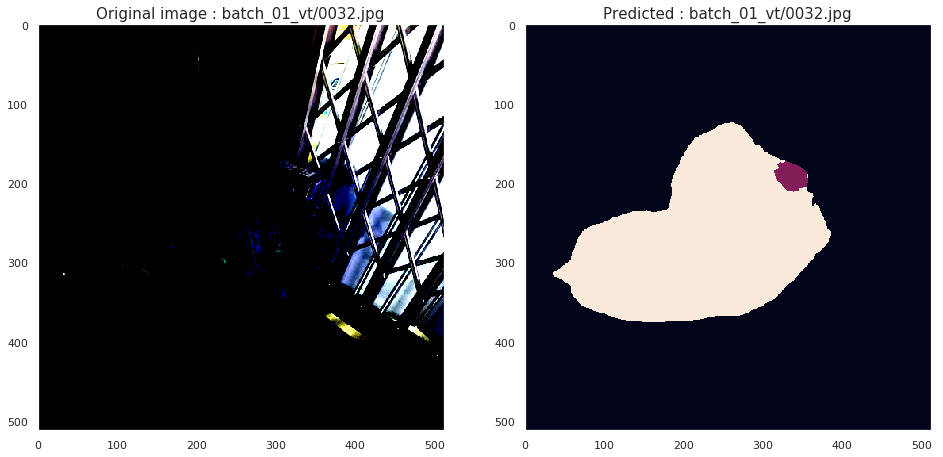

In [23]:
# 첫번째 batch의 추론 결과 확인
for imgs, image_infos in test_loader:
    image_infos = image_infos
    temp_images = imgs
    
    model.eval()
    # inference
    outs = model(torch.stack(temp_images).to(device))
    oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
    
    break

i = 3
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))

print('Shape of Original Image :', list(temp_images[i].shape))
print('Shape of Predicted : ', list(oms[i].shape))
print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(oms[i]))])

# Original image
ax1.imshow(temp_images[i].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("Original image : {}".format(image_infos[i]['file_name']), fontsize = 15)

# Predicted
ax2.imshow(oms[i])
ax2.grid(False)
ax2.set_title("Predicted : {}".format(image_infos[i]['file_name']), fontsize = 15)

plt.show()

## submission을 위한 test 함수 정의

In [24]:
def test(model, data_loader, device):
    size = 256
    transform = A.Compose([A.Resize(256, 256)])
    print('Start prediction.')
    model.eval()
    
    file_name_list = []
    preds_array = np.empty((0, size*size), dtype=np.long)
    
    with torch.no_grad():
        for step, (imgs, image_infos) in enumerate(tqdm(test_loader)):

            # inference (512 x 512)
            outs = model(torch.stack(imgs).to(device))
            oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
            
            # resize (256 x 256)
            temp_mask = []
            for img, mask in zip(np.stack(temp_images), oms):
                transformed = transform(image=img, mask=mask)
                mask = transformed['mask']
                temp_mask.append(mask)

            oms = np.array(temp_mask)
            
            oms = oms.reshape([oms.shape[0], size*size]).astype(int)
            preds_array = np.vstack((preds_array, oms))
            
            file_name_list.append([i['file_name'] for i in image_infos])
    print("End prediction.")
    file_names = [y for x in file_name_list for y in x]
    
    return file_names, preds_array

## submission.csv 생성

In [25]:
# sample_submisson.csv 열기
submission = pd.read_csv('./submission/sample_submission.csv', index_col=None)

# test set에 대한 prediction
file_names, preds = test(model, test_loader, device)

# PredictionString 대입
for file_name, string in zip(file_names, preds):
    submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
                                   ignore_index=True)

# submission.csv로 저장
submission.to_csv("./submission/deeplabv3plus_customloss_minloss.csv", index=False)

Start prediction.


  0%|          | 0/84 [00:00<?, ?it/s]

End prediction.


## Reference

